In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import re
import scipy
import itertools
import pickle
import time
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF as sm_ECDF
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import concurrent.futures
import attila_utils
import gem_tools

In [2]:
ar = gem_tools.read_active_reactions(groupdict={'m-control': ('all_control', 'MSBB'), 'm-AD-B2': ('SubtypeB2_AD', 'MSBB')})

In [3]:
gemsubsys = gem_tools.read_gem_excel()['SUBSYSTEM']
gemsubsys

ID
MAR03905       Glycolysis / Gluconeogenesis
MAR03907       Glycolysis / Gluconeogenesis
MAR04097       Glycolysis / Gluconeogenesis
MAR04099       Glycolysis / Gluconeogenesis
MAR04108       Glycolysis / Gluconeogenesis
                         ...               
MAR10129             Bile acid biosynthesis
MAR10130             Bile acid biosynthesis
MAR10131             Bile acid biosynthesis
MAR10132          Exchange/demand reactions
MAR13083    Metabolism of other amino acids
Name: SUBSYSTEM, Length: 13069, dtype: object

/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonesa7/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


['named-figure/n-reactions-ecdf.png', 'named-figure/n-reactions-ecdf.pdf']

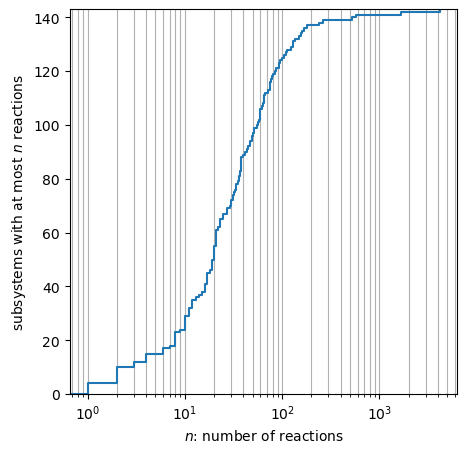

In [4]:
df = gemsubsys.value_counts(sort=True, ascending=True).to_frame('counts')
xs = np.logspace(0, df.max(), num=200)
ys = sm_ECDF(gemsubsys.value_counts(sort=True, ascending=True))(xs)
fig, ax = plt.subplots(figsize=(5,5))
sns.ecdfplot(df, x='counts', stat='count', ax=ax)
ax.set_xlabel(r'$n$: number of reactions')
ax.set_ylabel(r'subsystems with at most $n$ reactions')
ax.set_xscale('log')
ax.grid(axis='x', which='both')
attila_utils.savefig(fig, 'n-reactions-ecdf')

['named-figure/subsystem-rxn-counts.png',
 'named-figure/subsystem-rxn-counts.pdf']

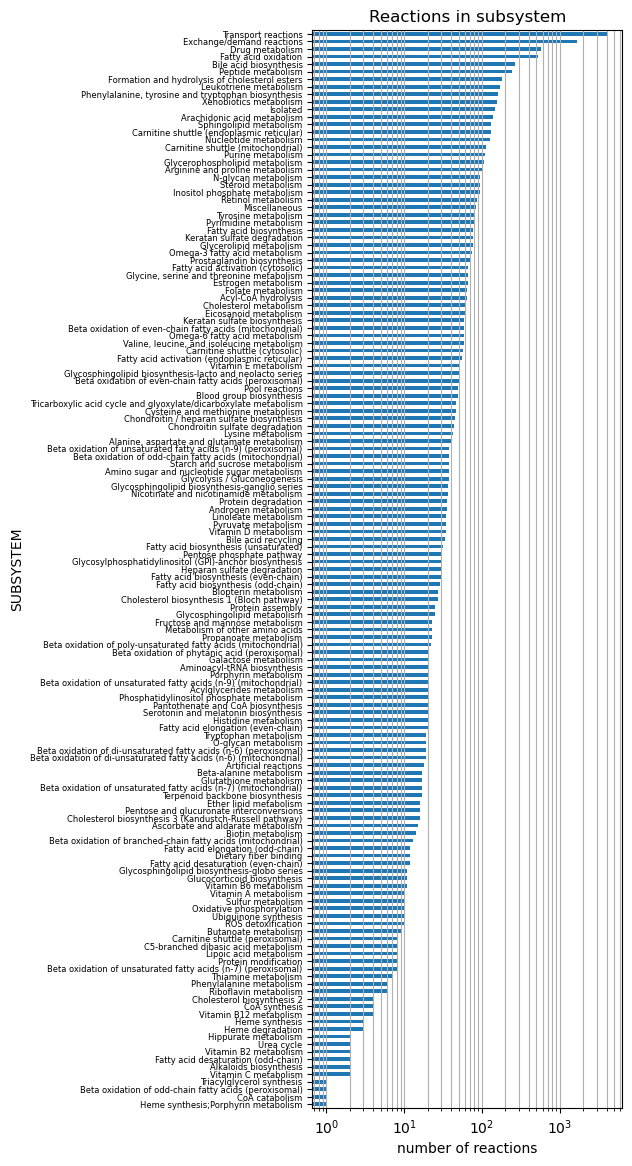

In [5]:
def subsystem_rxn_count(gemsubsys=gemsubsys, topk=None):
    fig, ax = plt.subplots(figsize=(4, 14 if topk is None else 5))
    s = gemsubsys.value_counts(sort=True, ascending=True)
    s = s if topk is None else s.iloc[-topk:]
    s.plot(kind='barh')
    ax.set_xscale('log')
    ax.set_xlabel(r'number of reactions')
    ax.grid(axis='x', which='both')
    ax.tick_params(axis='y', labelsize=6 if topk is None else 8)
    ax.set_title('Reactions in subsystem')
    return((fig, ax))

fig, ax = subsystem_rxn_count()
attila_utils.savefig(fig, 'subsystem-rxn-counts')

['named-figure/subsystem-rxn-counts-top30.png',
 'named-figure/subsystem-rxn-counts-top30.pdf']

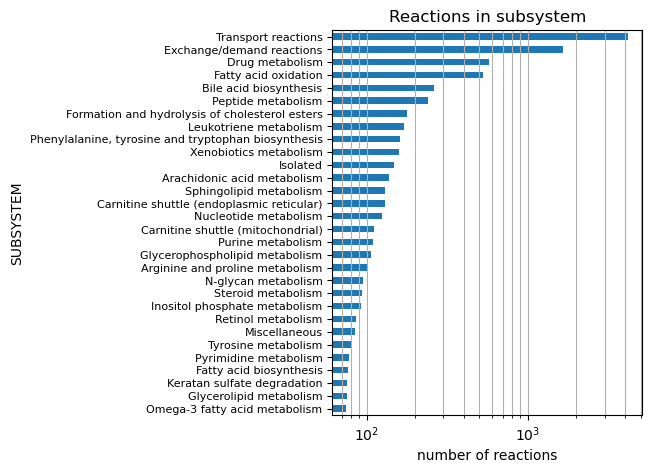

In [6]:
fig, ax = subsystem_rxn_count(topk=30)
attila_utils.savefig(fig, 'subsystem-rxn-counts-top30')

## Heatmaps
### Sphingolipids

['named-figure/Sphingolipid-metabolism.png',
 'named-figure/Sphingolipid-metabolism.pdf']

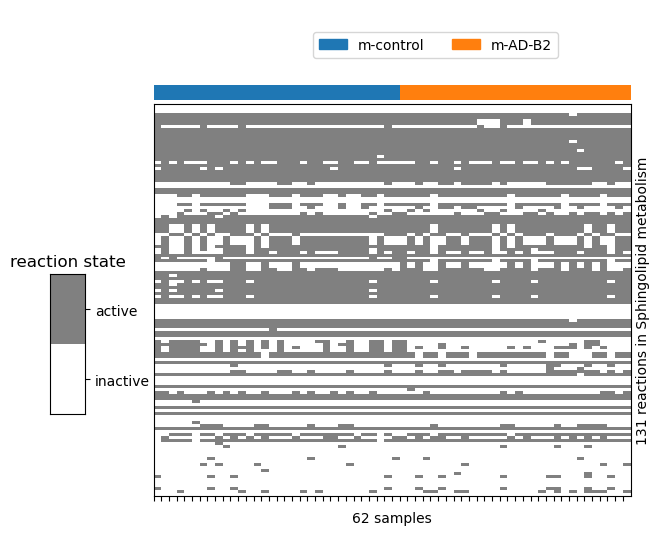

In [7]:
g = gem_tools.ar_clustermap(['Sphingolipid metabolism'], ar=ar, col_cluster=False)
attila_utils.savefig(g, 'Sphingolipid-metabolism')

In [8]:
pathways = pd.read_csv('../../resources/tunahan/Busra-2023-02-05/subsystem-pathway.csv')
pathways = pathways.groupby('pathway')['subsystem'].apply(lambda x: x.to_numpy())
pathways

pathway
Bile acid metabolism                             [Bile acid biosynthesis, Bile acid recycling]
Carnitine shuttle                            [Carnitine shuttle (cytosolic), Carnitine shut...
Cholesterol metabolism                       [Cholesterol biosynthesis 1 (Bloch pathway), C...
Fatty acid metabolism                        [Fatty acid activation (cytosolic), Fatty acid...
Glycerolipid metabolism                      [Glycerophospholipid metabolism, Glycerolipid ...
Glycosphingolipid metabolism                 [Glycosphingolipid biosynthesis-ganglio series...
Phosphatidylinositol phosphate metabolism    [Glycosylphosphatidylinositol (GPI)-anchor bio...
Name: subsystem, dtype: object

### Fatty acids

In [9]:
fatty_acid_pathway = pathways.loc['Fatty acid metabolism']
fatty_acid_pathway

array(['Fatty acid activation (cytosolic)',
       'Fatty acid activation (endoplasmic reticular)',
       'Fatty acid biosynthesis (even-chain)',
       'Fatty acid biosynthesis (odd-chain)',
       'Fatty acid biosynthesis (unsaturated)',
       'Fatty acid elongation (even-chain)',
       'Fatty acid elongation (odd-chain)',
       'Fatty acid desaturation (even-chain)',
       'Fatty acid desaturation (odd-chain)', 'Fatty acid biosynthesis',
       'Beta oxidation of even-chain fatty acids (peroxisomal)',
       'Beta oxidation of odd-chain fatty acids (peroxisomal)',
       'Beta oxidation of unsaturated fatty acids (n-9) (peroxisomal)',
       'Beta oxidation of phytanic acid (peroxisomal)',
       'Beta oxidation of di-unsaturated fatty acids (n-6) (peroxisomal)',
       'Beta oxidation of even-chain fatty acids (mitochondrial)',
       'Beta oxidation of odd-chain fatty acids (mitochondrial)',
       'Beta oxidation of unsaturated fatty acids (n-7) (mitochondrial)',
       'Bet

['named-figure/Fatty-acid-metabolism.png',
 'named-figure/Fatty-acid-metabolism.pdf']

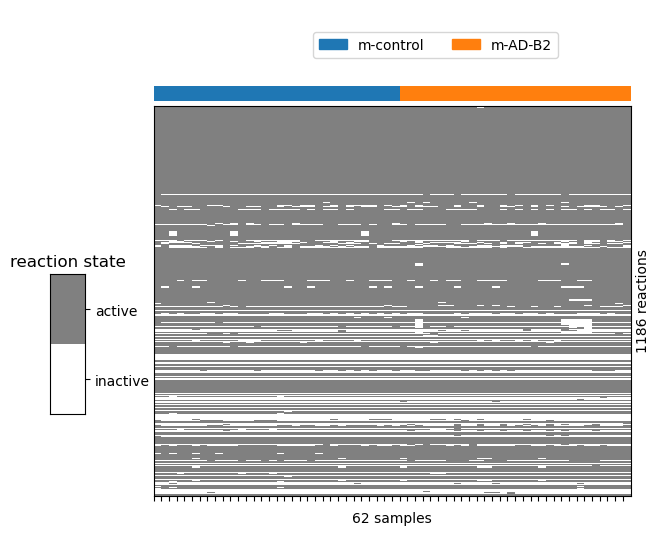

In [10]:
g = gem_tools.ar_clustermap(fatty_acid_pathway, ar=ar)
attila_utils.savefig(g, 'Fatty-acid-metabolism')

In [11]:
def subsys2fname(subsys):
    fname = re.sub('[ ()]+', '-', subsys).strip('-')
    return(fname)

subsys2fname('Beta oxidation of unsaturated fatty acids (n-7) (mitochondrial)')

'Beta-oxidation-of-unsaturated-fatty-acids-n-7-mitochondrial'

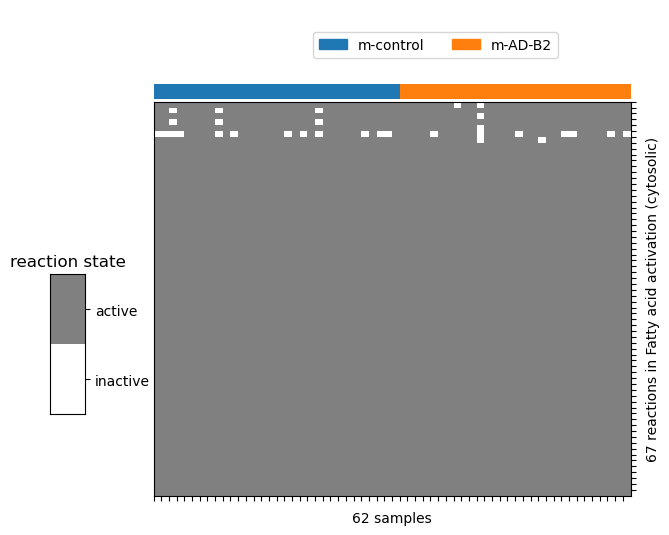

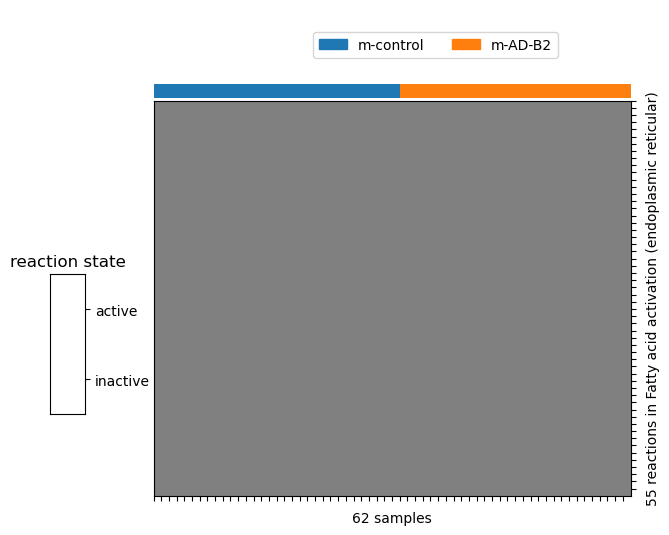

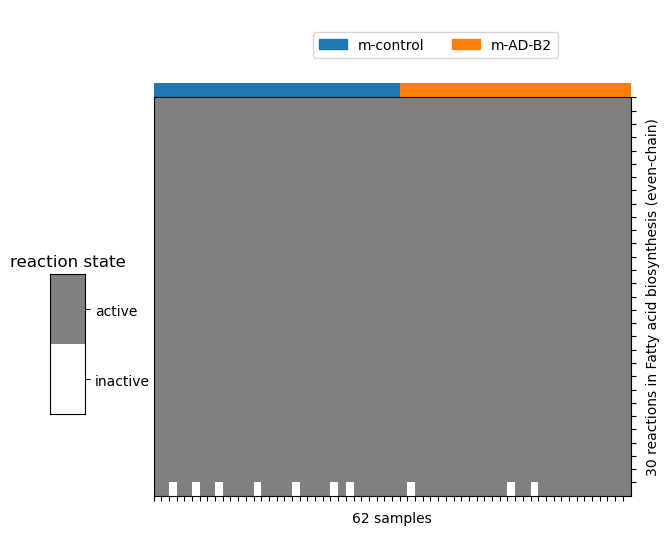

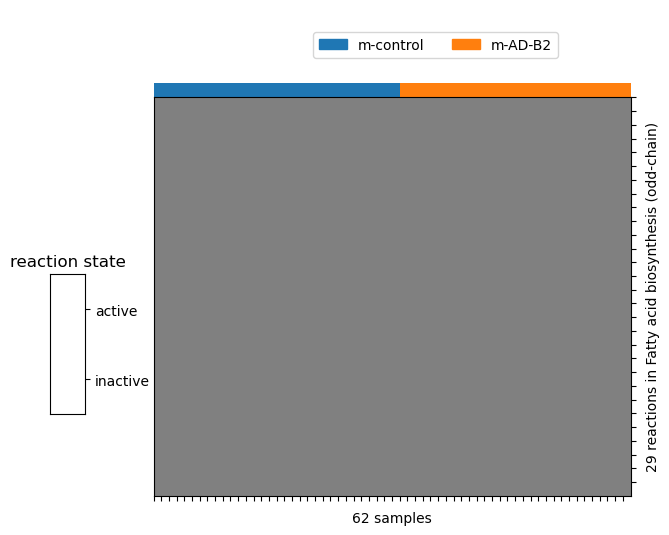

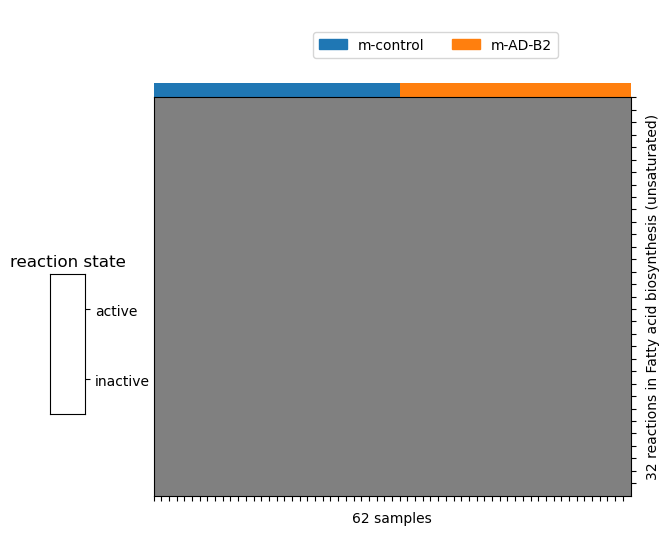

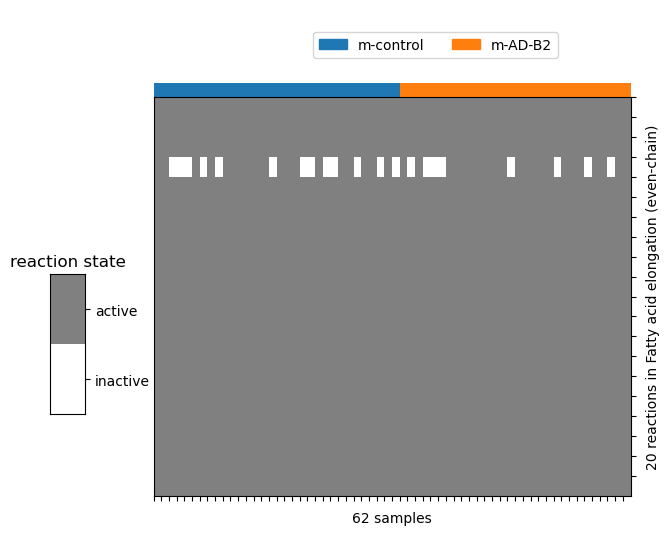

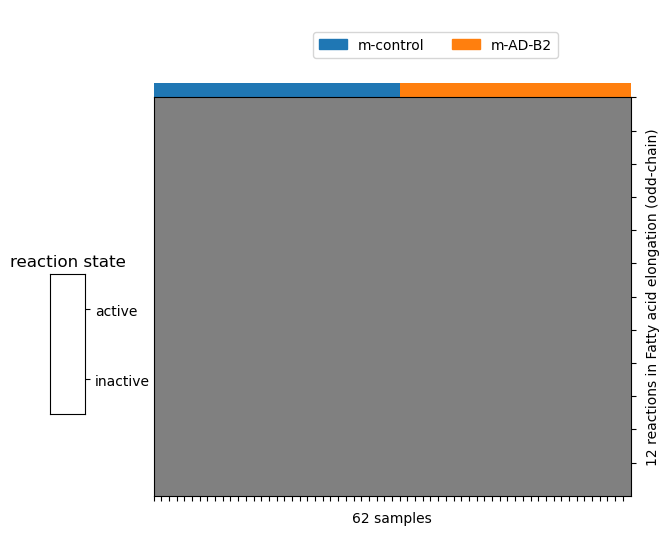

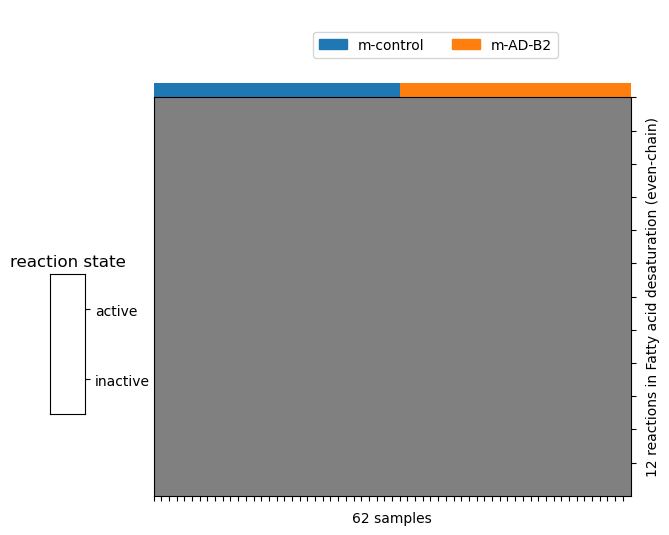

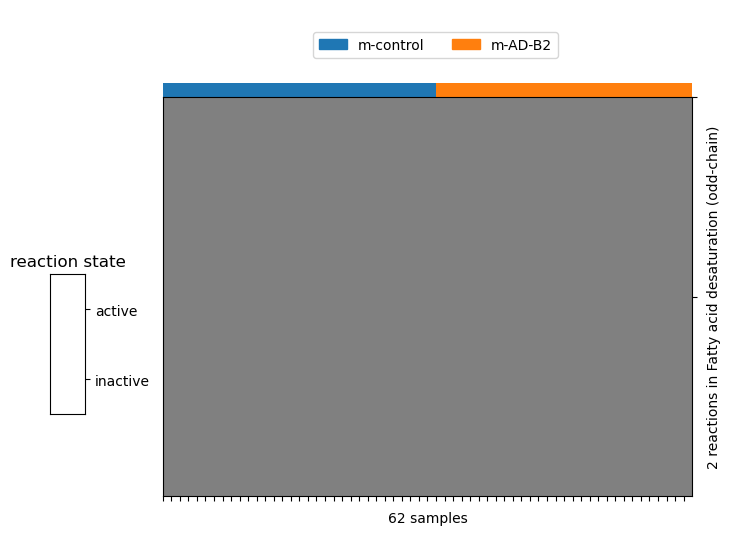

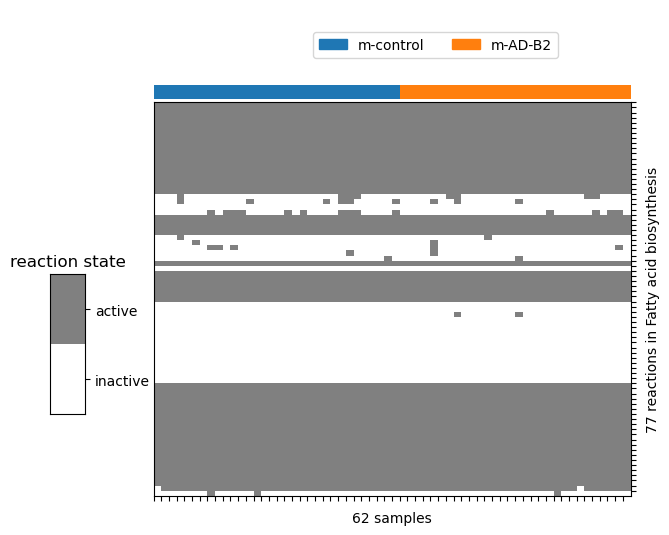

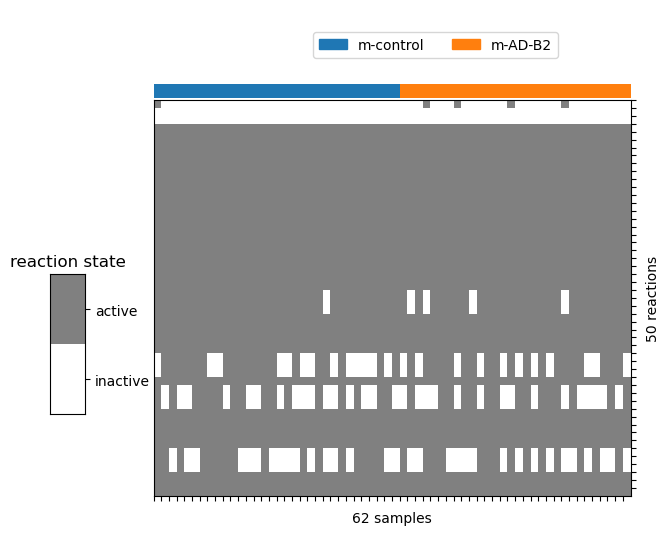

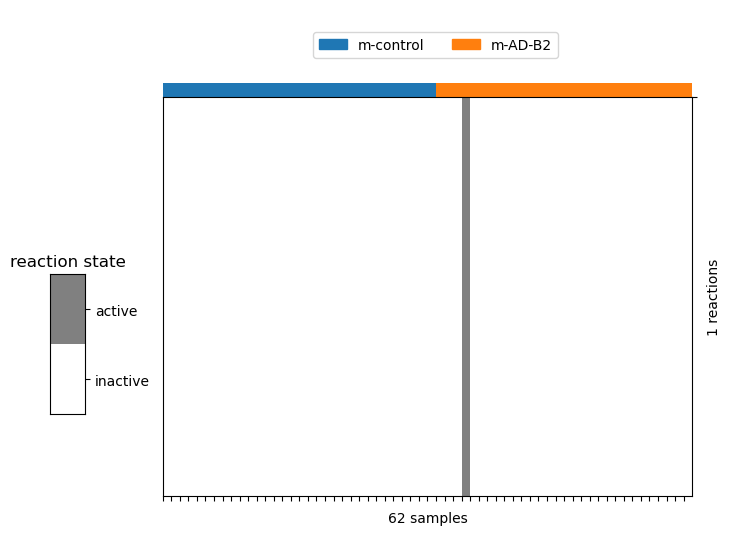

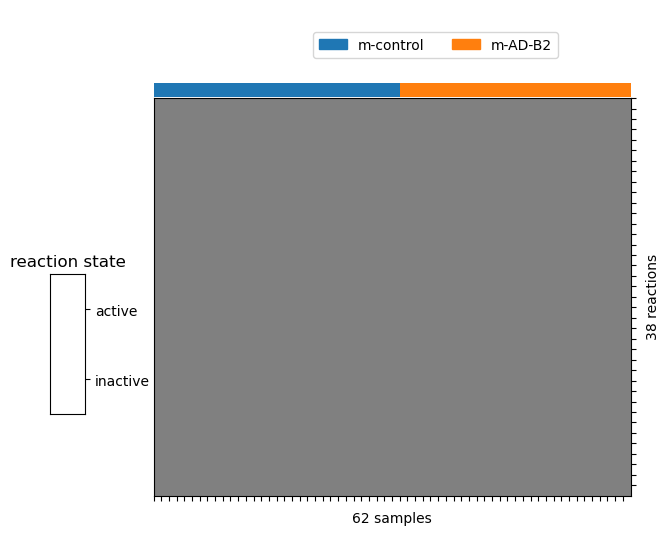

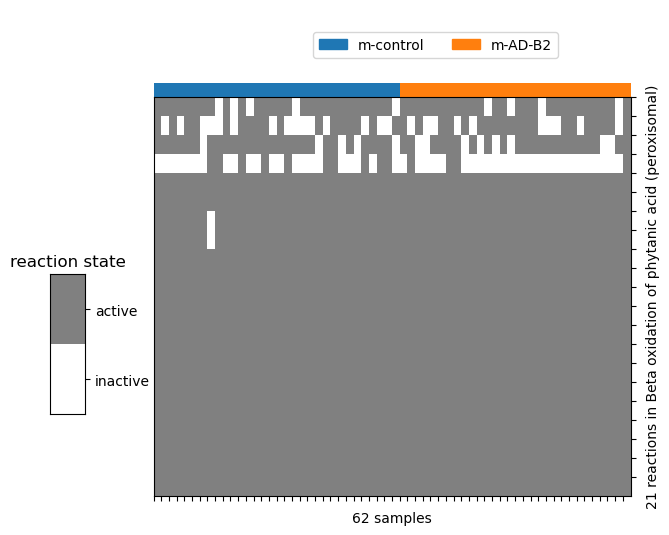

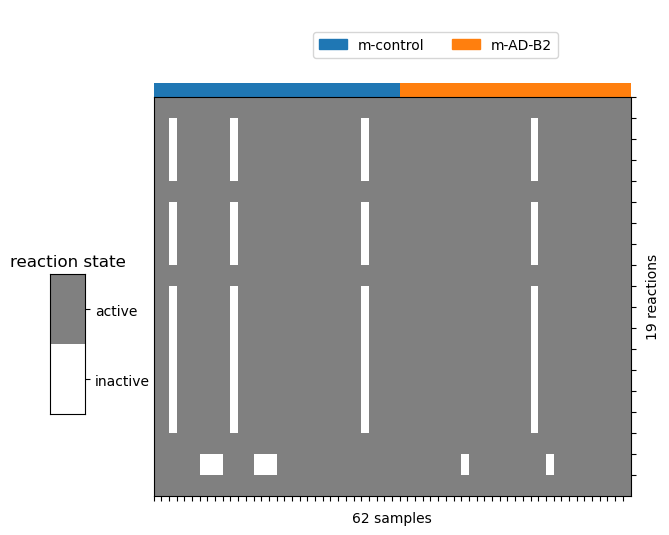

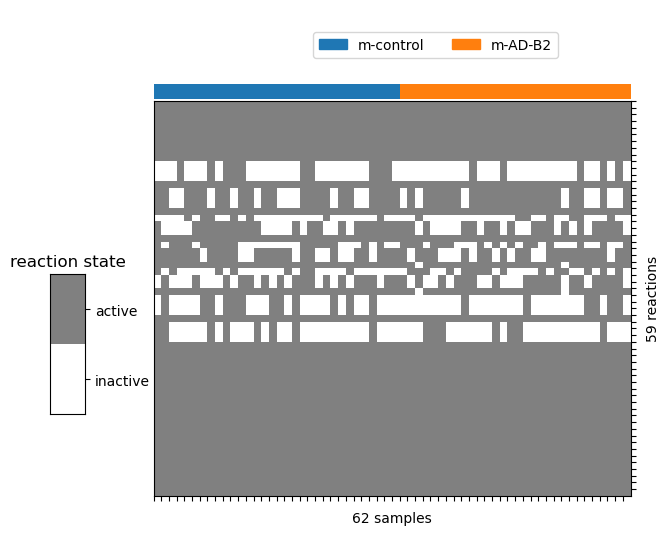

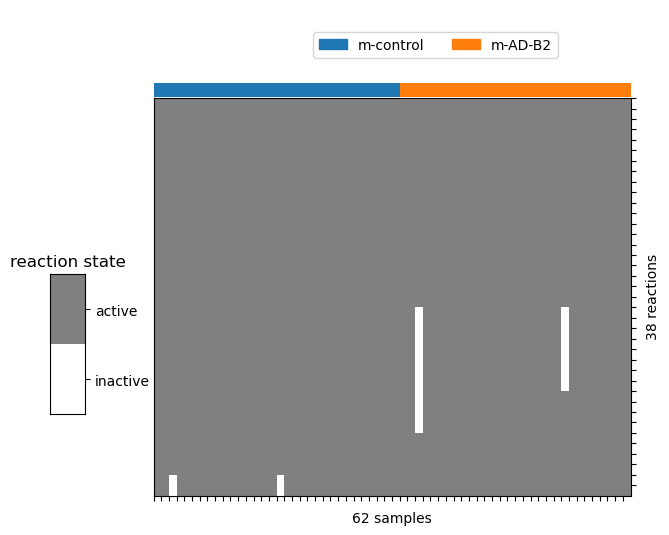

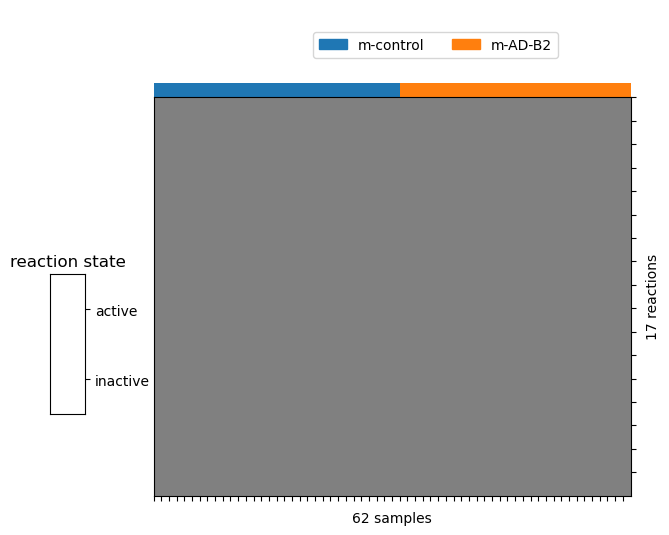

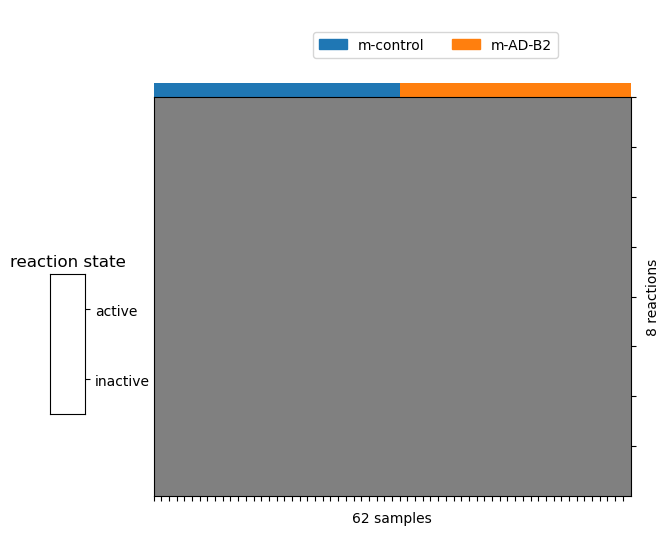

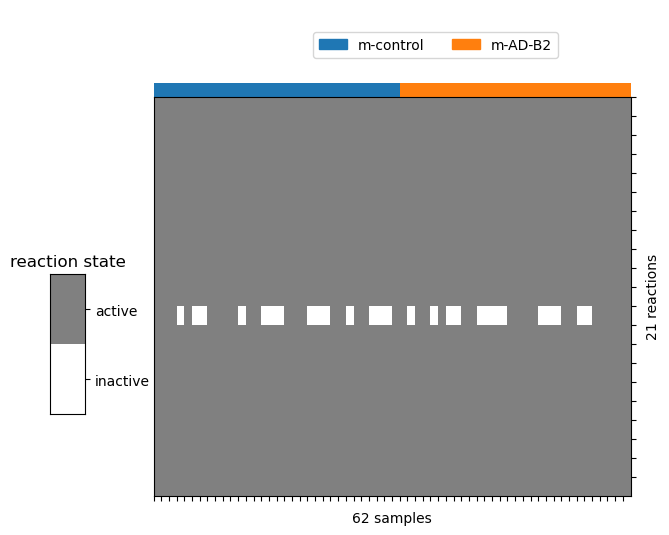

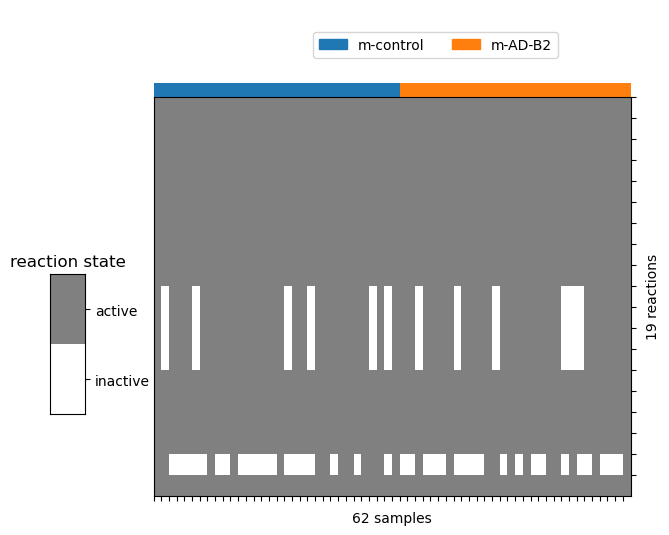

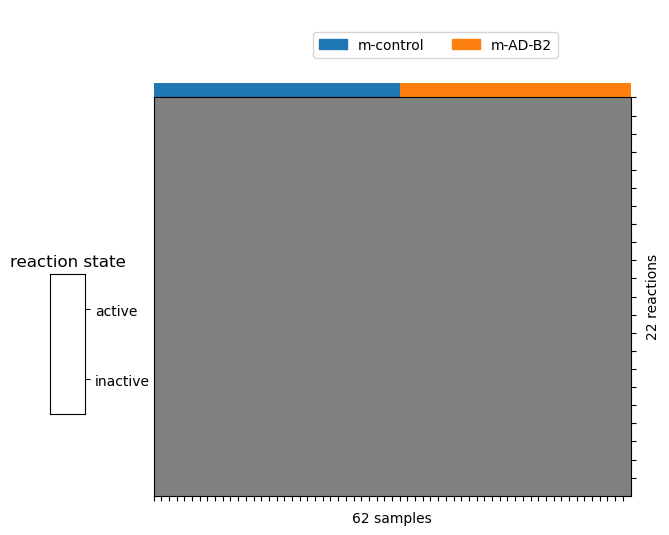

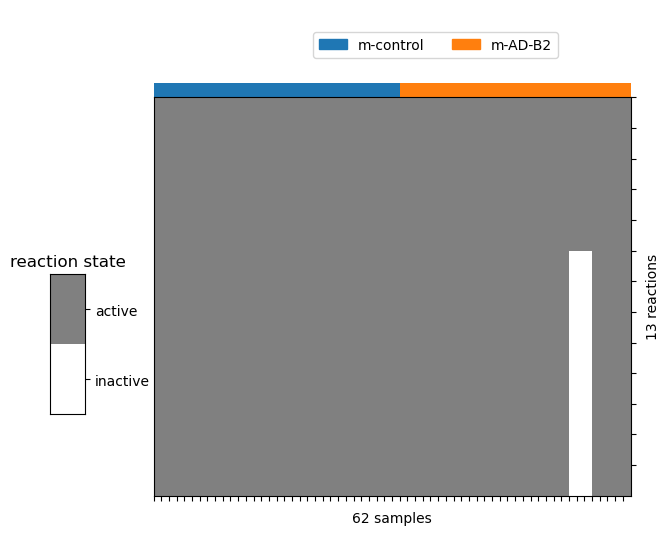

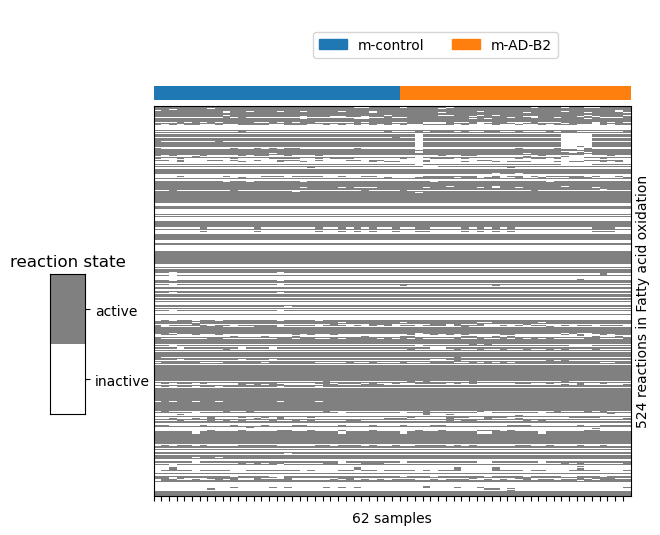

In [12]:
for subsys in fatty_acid_pathway:
    g = gem_tools.ar_clustermap([subsys], ar=ar)
    attila_utils.savefig(g, subsys2fname(subsys))
    del g

### Carnitine pathway

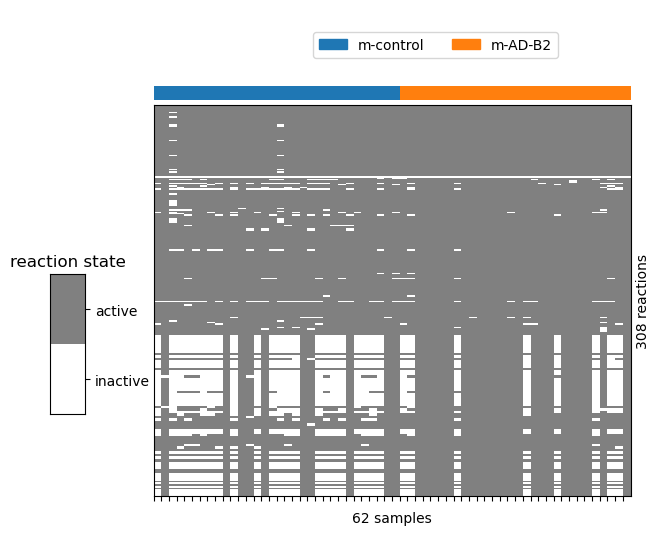

In [13]:
carnitine_pathway = pathways.loc['Carnitine shuttle']
g = gem_tools.ar_clustermap(carnitine_pathway, ar=ar)
attila_utils.savefig(g, 'Carnitine-metabolism')
del g

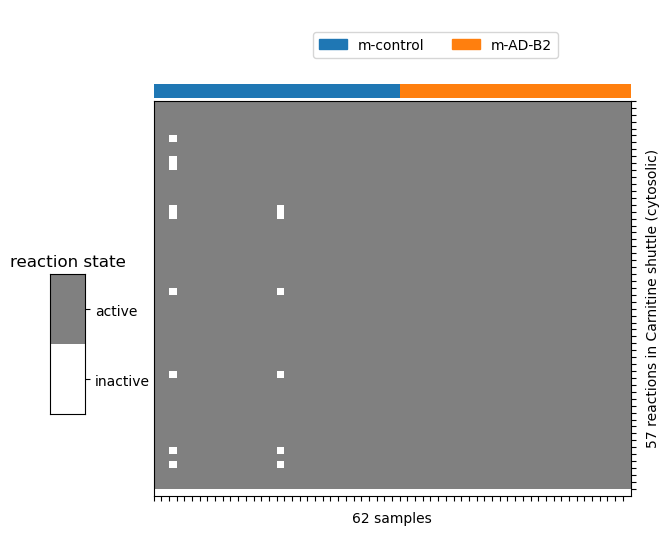

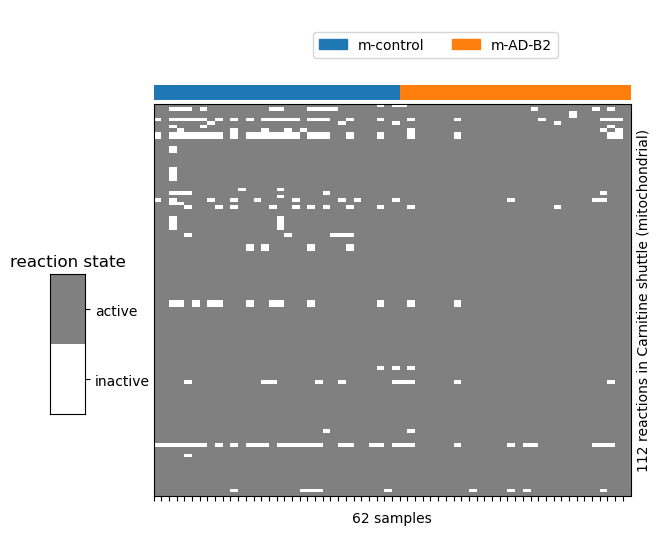

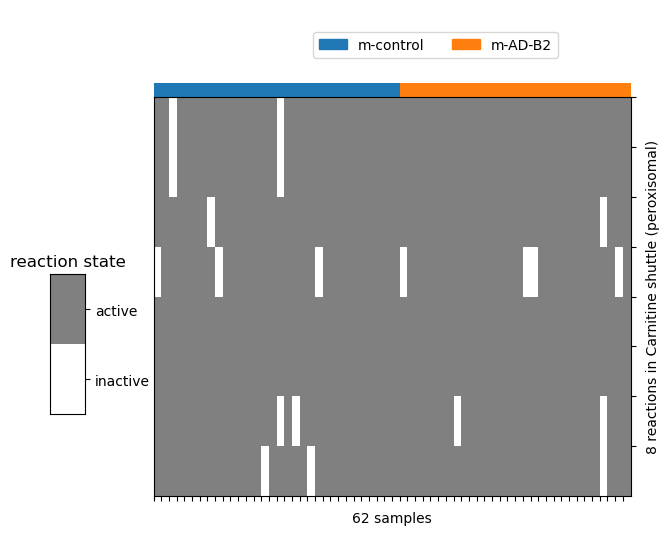

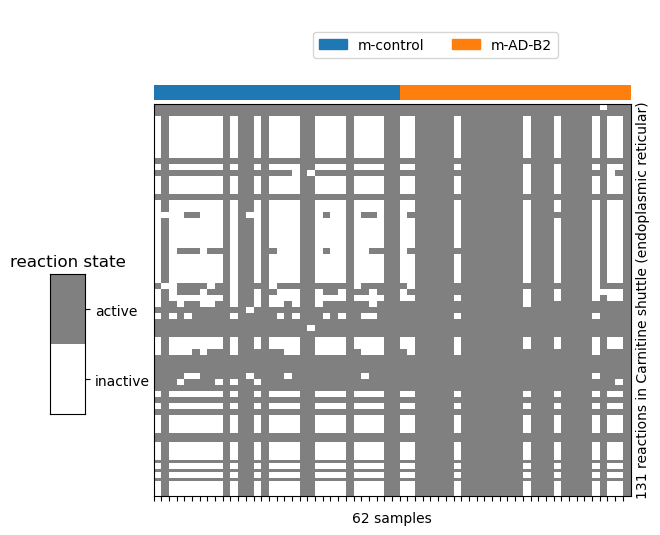

In [14]:
for subsys in carnitine_pathway:
    g = gem_tools.ar_clustermap([subsys], ar=ar)
    attila_utils.savefig(g, subsys2fname(subsys))
    del g

## Bayesian mixed effects logistic regression

Let $x=1$ encode an AD `disease_state`, and $x=0$ encode control.

The [inline documentation of the statsmodels.genmod.bayes_mixed_glm module](https://www.statsmodels.org/stable/_modules/statsmodels/genmod/bayes_mixed_glm.html) reveals that

* the error distribution $Y$ given the linear predictor $\eta$ is Bernoulli $Y \sim \mathrm{Binom}(n=1, p)$
* link function $g(\mu) = \mathrm{E}_b(\eta) = x\beta + Zb$ is logit:
\begin{equation}
\mathrm{E}_b(\eta) = \mathrm{E}_b(x\beta + Zb) = x\beta = \mathrm{logit}(\pi) = \mathrm{log}(\pi / (1 - \pi))
\end{equation}
    * The first equation follows from $\mathrm{E}_b(b) = 0$ since $b \sim N(0, G)$, i.e $b$ is normally distributed with mean 0
    * The second equation follows from $x\beta = \eta = g(\mu)$, where the link function $g = \mathrm{logit}$ and from $\mathrm{E}(Y \, |\, \eta) = \mu = \pi$, where $\pi$ is the expected proportion of active reactions ($Y=1$)
    * The last expression $\mathrm{log}(\pi / (1 - \pi))$ is the posterior log odds

Therefore
\begin{eqnarray}
x\beta &=& \mathrm{log} \frac{\pi(x)}{1 - \pi(x)} \\
\beta &=& \mathrm{log} \frac{\pi(x=1)}{1 - \pi(x=1)} \; \Leftrightarrow \; e^\beta = \frac{\pi(x=1)}{1 - \pi(x=1)}
\end{eqnarray}
which means that we can interpret $\beta$ as the posterior log odds ratio of reaction state for AD w.r.t control.  (Note that if $x=0 \Rightarrow 0\beta = 0 = \mathrm{log}(\pi(x=0) / (1 - \pi(x=0)))$, so that the second equation above follows from the first one.)


## Model fitting

In [15]:
def print_results(subsys, vcp_p=0.2, fe_p=2):
    print('Subsystem(s): ' + ', '.join(subsys))
    for fit_method_name, fit_method in zip(['variational Bayes', 'Laplace approximation'], ['fit_vb', 'fit_map']):
        res = gem_tools.myBinomialBayesMixedGLM(subsys, ar=ar, vcp_p=vcp_p, fe_p=fe_p, fit_method=fit_method)
        print('\n' * 2, 'Fit method: ' + fit_method_name, '\n', res.summary())
    return(None)

In [16]:
print_results(['Carnitine shuttle (endoplasmic reticular)'])

Subsystem(s): Carnitine shuttle (endoplasmic reticular)


 Fit method: variational Bayes 
                                         Binomial Mixed GLM Results
                                                             Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
-----------------------------------------------------------------------------------------------------------
Intercept                                                       M     0.0420   0.0738                      
C(disease_state, levels=["m-control", "m-AD-B2"])[T.m-AD-B2]    M     8.8931   0.1421                      
Reactions                                                       V     1.5179   0.0525 4.563   4.108   5.068
Subjects                                                        V     1.6684   0.0656 5.304   4.652   6.047
Parameter types are mean structure (M) and variance structure (V)
Variance parameters are modeled as log standard deviations


 Fit method: Laplace approximation 
                               

In [17]:
print_results(['Sphingolipid metabolism'])

Subsystem(s): Sphingolipid metabolism


 Fit method: variational Bayes 
                                         Binomial Mixed GLM Results
                                                             Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
-----------------------------------------------------------------------------------------------------------
Intercept                                                       M    -0.2209   0.0446                      
C(disease_state, levels=["m-control", "m-AD-B2"])[T.m-AD-B2]    M     0.1362   0.0641                      
Reactions                                                       V     1.7017   0.0518 5.483   4.943   6.083
Subjects                                                        V    -0.4121   0.0883 0.662   0.555   0.790
Parameter types are mean structure (M) and variance structure (V)
Variance parameters are modeled as log standard deviations


 Fit method: Laplace approximation 
                                         Binomial

In [18]:
fpath = '../../results/2023-02-10-gem-subsystems/fitted_models.pickle'
if os.path.exists(fpath):
    print('exists')
    with open(fpath, 'rb') as f:
        fitted_models = pickle.load(f)
else:
    subsystems = gemsubsys.unique()
    d = {subsys: myBinomialBayesMixedGLM([subsys], 'm-control', 'm-AD-B2', vcp_p=0.2, fe_p=2, fit_method='fit_map') for subsys in subsystems}
    fitted_models = {'m-AD-B2 wrt m-control': pd.Series(d)}
    with open(fpath, 'wb') as f:
        pickle.dump(fitted_models, f)

fittedm = fitted_models['m-AD-B2 wrt m-control']

exists


## Bayes factors (BFs)

### Benchmarking

I implemented a parallellized (asynchronously launched parallel processes using `concurrent.futures.ProcessPoolExecutor`) computation of Bayes factors. Below we look at the dependence of runtime on the following variables:
1. size of the subsystem (number of reactions)
1. number of replicas for calculating BF
1. the max_workers of asynchronous execution

In [19]:
subsysl = ['Sulfur metabolism', 'Arginine and proline metabolism', 'Fatty acid oxidation']#[:2]
replicasl = [15, 60, 240, 960]#[:2]
max_workersl = [1, 2, 6]#[1:]

def time_BF(subsysl, replicasl, max_workersl, fittedm=fittedm):
    def time_BF_helper(subsys, replicas, max_workers):
        m = fittedm.loc[subsys]
        start = time.time()
        LLs = gem_tools.get_marginal_likelihoods(m, replicas=replicas, returnBF=False, asynchronous=True, max_workers=max_workers)
        runtime = time.time() - start
        if max_workers == 6:
            fpath = '../../results/2023-02-10-gem-subsystems/LLs-' + subsys2fname(subsys) + '-' + str(int(replicas)) + '-replicas.csv'
        return(runtime)
    lll = [[[time_BF_helper(subsys, replicas, max_workers) for subsys in subsysl] for replicas in replicasl] for max_workers in max_workersl]
    a = np.array(lll)
    def turn2d_array2df(i, a, subsysl):
        subsys_size = gemsubsys.value_counts().loc[subsysl[i]]
        df = pd.DataFrame(a[:, :, i], columns=replicasl, index=max_workersl).rename_axis('max_workers', axis=0).rename_axis('replicas', axis=1).stack().to_frame(subsys_size).rename_axis('subsystem size', axis=1)
        return(df)
    l = [turn2d_array2df(i, a, subsysl) for i in range(len(subsysl))]
    val = pd.concat(l, axis=1).stack().to_frame('runtime')
    return(val)

fpath = '../../results/2023-02-10-gem-subsystems/runtime_BF.csv'
if not os.path.exists(fpath):
    runtime_BF = time_BF(subsysl, replicasl, max_workersl, fittedm=fittedm)
    runtime_BF.to_csv(fpath)

runtime_BF = pd.read_csv(fpath)
runtime_BF.head()

,max_workers,replicas,subsystem size,runtime
0,1,15,10,3.215534
1,1,15,100,6.185014
2,1,15,524,19.182534
3,1,60,10,4.405974
4,1,60,100,14.983103


['named-figure/benchmark-replicas-runtime.png',
 'named-figure/benchmark-replicas-runtime.pdf']

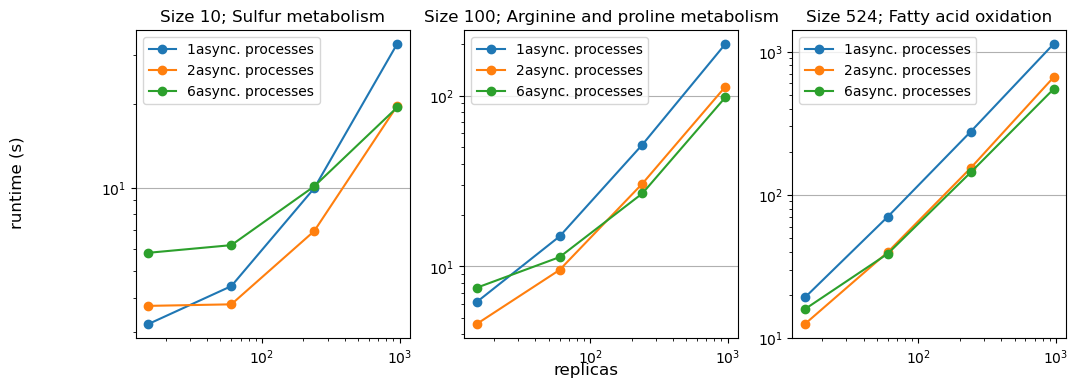

In [20]:
fig, ax = plt.subplots(1, len(subsysl), sharex=True, figsize=(12, 4))
for axi, subsys in zip(ax, subsysl):
    subsys_size = gemsubsys.value_counts().loc[subsys]
    for max_worker in max_workersl:
        dat = runtime_BF.loc[(runtime_BF.max_workers == max_worker) & (runtime_BF['subsystem size'] == subsys_size)]
        axi.plot('replicas', 'runtime', data=dat, label=str(max_worker) + 'async. processes', marker='o')
    axi.legend()
    axi.set_title('Size ' + str(subsys_size) + '; ' + subsys)
    axi.set_xscale('log')
    axi.set_yscale('log')
    axi.grid(axis='y')

fig.supxlabel('replicas')
fig.supylabel('runtime (s)')
attila_utils.savefig(fig, 'benchmark-replicas-runtime')

['named-figure/subsys_size-runtime.png',
 'named-figure/subsys_size-runtime.pdf']

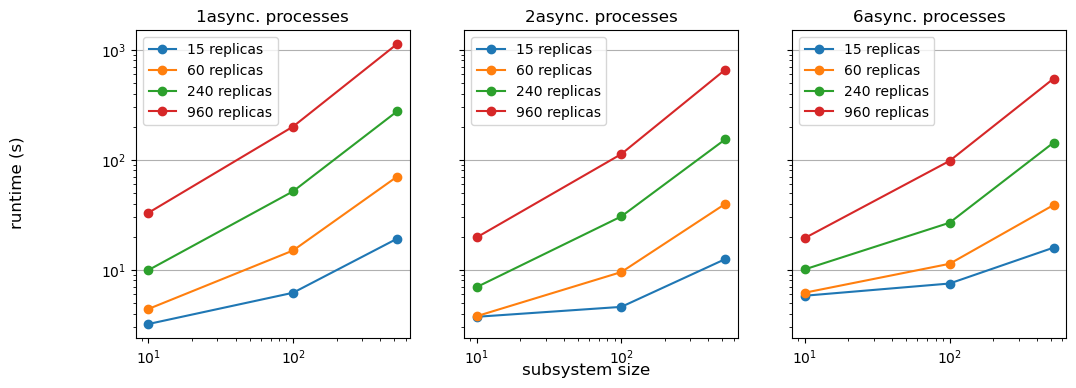

In [21]:
fig, ax = plt.subplots(1, len(max_workersl), sharex=True, figsize=(12, 4), sharey=True)
for axi, max_workers in zip(ax, max_workersl):
    #subsys_size = gemsubsys.value_counts().loc[subsys]
    for replicas in replicasl:
        dat = runtime_BF.loc[(runtime_BF.max_workers == max_workers) & (runtime_BF.replicas == replicas)]
        axi.plot('subsystem size', 'runtime', data=dat, label=str(replicas) + ' replicas', marker='o')
    axi.legend()
    axi.set_title(str(max_workers) + 'async. processes')
    axi.set_xscale('log')
    axi.set_yscale('log')
    axi.grid(axis='y')

fig.supxlabel('subsystem size')
fig.supylabel('runtime (s)')
attila_utils.savefig(fig, 'subsys_size-runtime')

### Computation of all BFs

Processing the m-AD_B2 data took $13257.6\mathrm{s} \approx 3.7 \mathrm{h}$

In [22]:
fpath = '../../results/2023-02-10-gem-subsystems/BF_AD_B2.csv'
if os.path.exists(fpath):
    BF_AD_B2 = pd.read_csv(fpath, index_col='subsystem')
else:
    replicas = 240
    max_workers = 2
    start = time.time()
    BF_AD_B2 = fittedm.dropna().apply(lambda m: gem_tools.get_marginal_likelihoods(m, replicas=replicas, returnBF=True, asynchronous=True, max_workers=max_workers))
    runtime = time.time() - start
    print(runtime)
    BF_AD_B2 = BF_AD_B2.reindex_like(fittedm)
    BF_AD_B2 = BF_AD_B2.rename_axis('subsystem').to_frame('2 log BF')
    BF_AD_B2.to_csv(fpath)

### Illustration of BF-related concepts

['named-figure/cov_params.png', 'named-figure/cov_params.pdf']

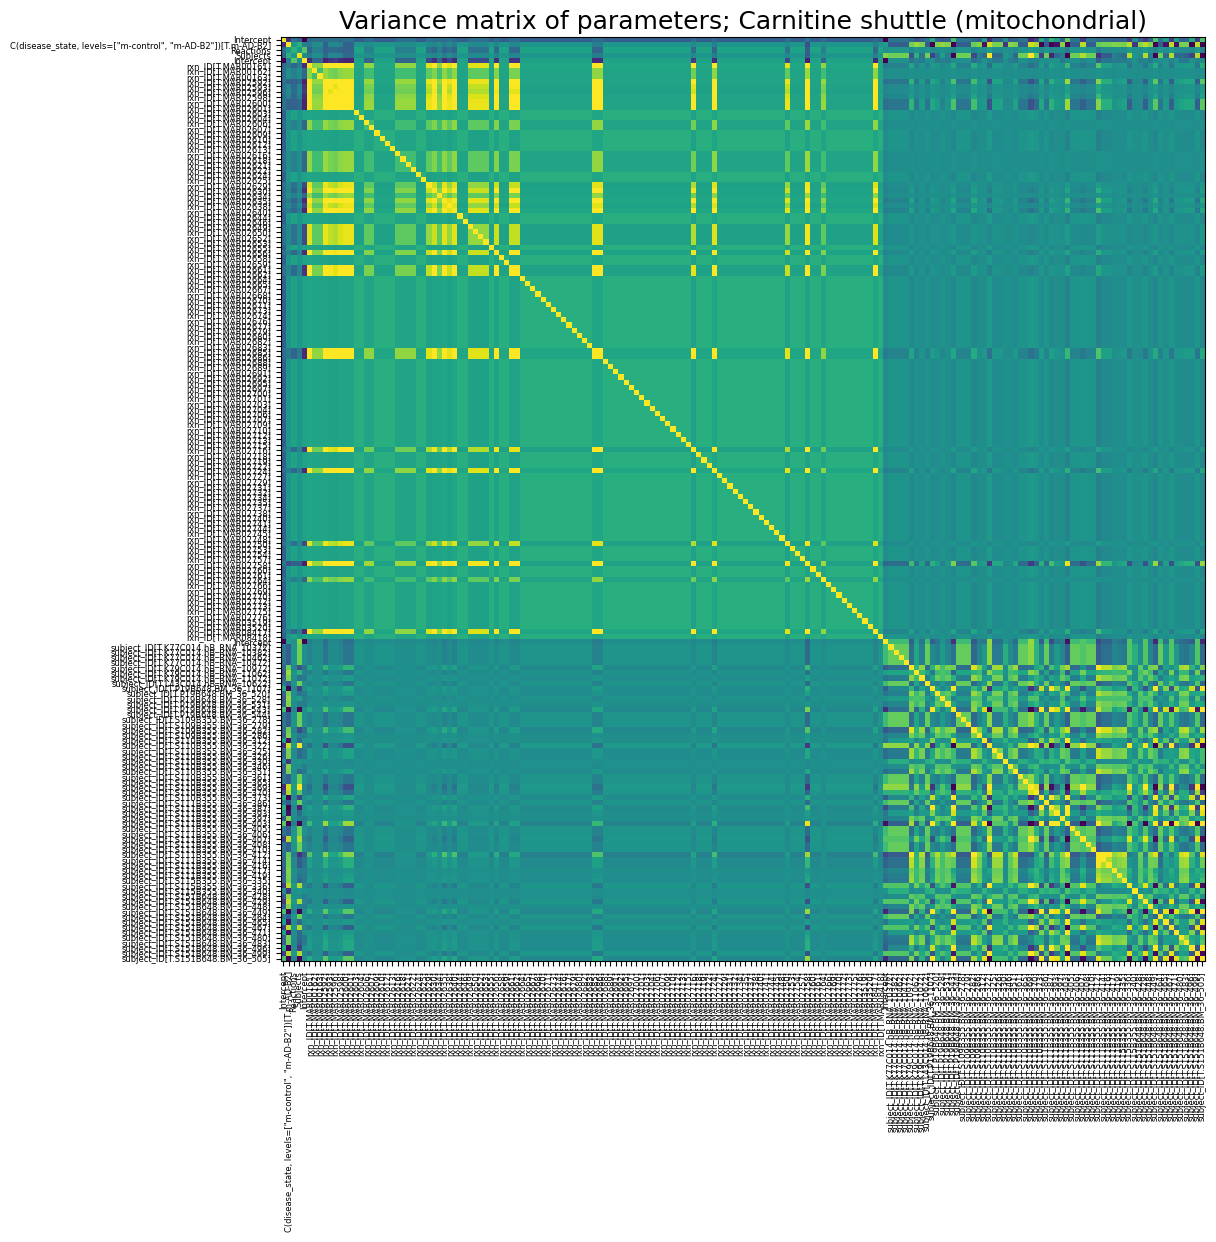

In [23]:
subsys = 'Carnitine shuttle (mitochondrial)'
m = fittedm.loc[subsys]
fig, ax = plt.subplots(figsize=(12, 12))
corrmat = m.cov_params()
ax.imshow(corrmat, vmin=-0.025, vmax=0.025)
ax.set_xticks(range(corrmat.shape[0]))
ax.set_yticks(range(corrmat.shape[0]))
ax.set_xticklabels(m.model.names, fontsize=6, rotation=90)
ax.set_yticklabels(m.model.names, fontsize=6)
ax.set_title('Variance matrix of parameters; ' + subsys, fontsize=18)
attila_utils.savefig(fig, 'cov_params')

['named-figure/marginal-likelihood-M0-vs-M1.png',
 'named-figure/marginal-likelihood-M0-vs-M1.pdf']

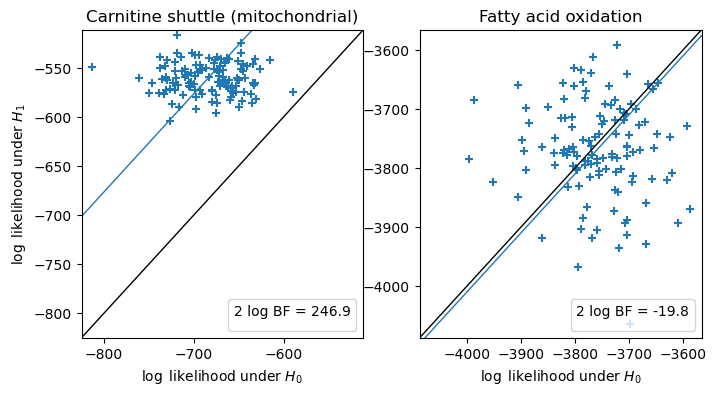

In [24]:
replicas = 120
subsysl = ['Carnitine shuttle (mitochondrial)', 'Fatty acid oxidation']
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for axi, subsys in zip(ax, subsysl):
    m = fittedm.loc[subsys]
    fpath = '../../results/2023-02-10-gem-subsystems/LLs-' + subsys2fname(subsys) + '.csv'
    if os.path.exists(fpath):
        LLs = pd.read_csv(fpath)
    else:
        LLs = gem_tools.get_marginal_likelihoods(m, replicas=replicas, returnBF=False, asynchronous=True)
        LLs.to_csv(fpath, index=False)
    axi.scatter(x='M0', y='M1', data=LLs, marker='+')
    avg_LL = LLs.mean().mean()
    axi.axline((avg_LL, avg_LL), slope=1, color='k', linewidth=1)
    l = LLs.mean().to_list()
    l.reverse()
    axi.axline(l, slope=1, linewidth=1)
    #axi.text(avg_LL, avg_LL, s=r'$x=y$', rotation=45, horizontalalignment='center', verticalalignment='bottom')
    twice_log_BF = gem_tools.BF_from_marginal_likelihoods(LLs)
    legend_title = '2 log BF = {:.1f}'.format(gem_tools.BF_from_marginal_likelihoods(LLs))
    axi.legend([], [], title=legend_title, loc='lower right')
    xlim = axi.get_xlim()
    ylim = axi.get_ylim()
    axi.set_xlim(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    axi.set_ylim(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    axi.set_title(subsys)
    axi.set_xlabel(r'$\log$ likelihood under $H_0$')

ax[0].set_ylabel(r'$\log$ likelihood under $H_1$')
attila_utils.savefig(fig, 'marginal-likelihood-M0-vs-M1')

['named-figure/Carnitine-shuttle-mitochondrial-Fatty-acid-oxydation.png',
 'named-figure/Carnitine-shuttle-mitochondrial-Fatty-acid-oxydation.pdf']

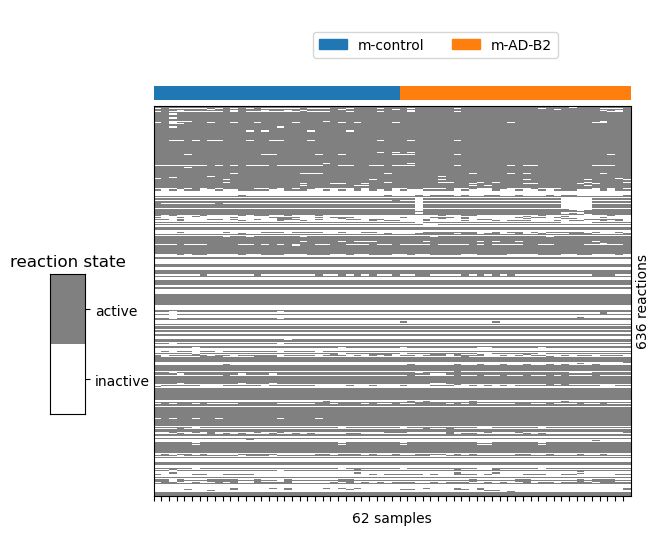

In [25]:
g = gem_tools.ar_clustermap(subsysl, ar=ar, col_cluster=False)
attila_utils.savefig(g, 'Carnitine-shuttle-mitochondrial-Fatty-acid-oxydation')

## Volcano plot

In [26]:
def exp_transform(fe, alpha=0.005):
    fe = fe.copy()
    fe['OR'] = fe.fe_mean.apply(np.exp)
    half_CI = fe.fe_sd.apply(lambda x: scipy.stats.norm.ppf(1 - alpha, loc=0, scale=x))
    fe['Lbound'] = (fe.fe_mean - half_CI).apply(np.exp)
    fe['Ubound'] = (fe.fe_mean + half_CI).apply(np.exp)
    fe['Lhalf_CI'] = fe['OR'] - fe['Lbound']
    fe['Uhalf_CI'] = fe['Ubound'] - fe['OR']
    return(fe)

In [27]:
fe = pd.concat([fittedm.dropna().apply(lambda m: getattr(m, fe)[1]).to_frame(fe) for fe in ['fe_mean', 'fe_sd']], axis=1)
fe = exp_transform(fe)
fe = fe.reindex(fittedm.index)
fe = pd.concat([fe, BF_AD_B2, gemsubsys.value_counts().to_frame('num_reactions')], axis=1)
fe = fe.sort_values('2 log BF', ascending=False).dropna()
fe['BF rank'] = np.array(range(fe.shape[0])) + 1
fe = fe.reindex(fittedm.index)
fe['log10 num_reactions'] = fe['num_reactions'].apply(np.log10)
copper = get_cmap('copper')
s = fe['log10 num_reactions']
fe['colors'] = s.apply(lambda x: copper(x / s.max()))
#fe = fe.sort_values('fe_mean', ascending=True)
fpath = '../../results/2023-02-10-gem-subsystems/summary.csv'
fe.to_csv(fpath)
fe

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_37213/917338949.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  copper = get_cmap('copper')


,fe_mean,fe_sd,OR,Lbound,Ubound,Lhalf_CI,Uhalf_CI,2 log BF,num_reactions,BF rank,log10 num_reactions,colors
Glycolysis / Gluconeogenesis,-0.065998,0.216045,0.936133,0.536606,1.633126,0.399527,0.696993,1.089753,38.0,67.0,1.579784,"(0.5377161364543347, 0.3400517647058824, 0.216..."
Starch and sucrose metabolism,-0.385610,0.315226,0.680035,0.301925,1.531667,0.378111,0.851632,6.924779,38.0,30.0,1.579784,"(0.5377161364543347, 0.3400517647058824, 0.216..."
Galactose metabolism,-0.060960,0.193411,0.940861,0.571693,1.548417,0.369168,0.607556,-0.879466,21.0,104.0,1.322219,"(0.45051892513741554, 0.28490823529411763, 0.1..."
Fructose and mannose metabolism,0.134262,0.243094,1.143692,0.611460,2.139196,0.532233,0.995503,0.895235,23.0,72.0,1.361728,"(0.4650517936902354, 0.29409882352941175, 0.18..."
Pentose and glucuronate interconversions,-0.128808,0.210328,0.879142,0.511413,1.511286,0.367729,0.632144,-2.054832,16.0,116.0,1.204120,"(0.4117646089965626, 0.26039999999999996, 0.16..."
...,...,...,...,...,...,...,...,...,...,...,...,...
CoA catabolism,0.227474,0.803348,1.255425,0.158530,9.941943,1.096895,8.686519,0.050810,1.0,90.0,0.000000,"(0.0, 0.0, 0.0, 1.0)"
Triacylglycerol synthesis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.0)"
Hippurate metabolism,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.0)"
Peptide metabolism,0.273936,0.817173,1.315131,0.160259,10.792302,1.154871,9.477172,0.634209,242.0,75.0,2.383815,"(0.8138406389579119, 0.5146729411764706, 0.327..."


/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_37213/3510573879.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


['named-figure/volcano-plot_m-AD-B2.png',
 'named-figure/volcano-plot_m-AD-B2.pdf']

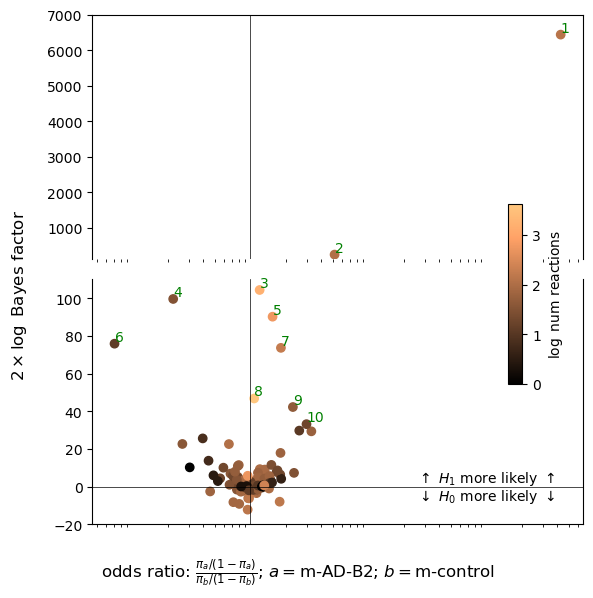

In [28]:
def volcano_plot(ax, fe, rank=None):
    ax.scatter(x='OR', y='2 log BF', c='colors', data=fe)
    df = fe.copy()
    if rank is not None:
        df = df.sort_values('2 log BF', ascending=False).dropna()
        for subsys, r in zip(df.index, df['BF rank']):
            x = df.loc[subsys, 'OR']
            y = df.loc[subsys, '2 log BF']
            if r <= rank:
                s = str(np.int64(r))
                ax.text(x, y, s, verticalalignment='bottom', horizontalalignment='left', color='green')
    ax.set_xscale('log')
    ax.axvline(x=1, color='k', linewidth=0.5)
    return(ax)

control_group = 'm-control'
AD_group = 'm-AD-B2'

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
subsys2drop = ['Carnitine shuttle (endoplasmic reticular)', 'Carnitine shuttle (mitochondrial)']
volcano_plot(ax[0], fe.loc[subsys2drop], rank=2)
volcano_plot(ax[1], fe.drop(subsys2drop), rank=10)
ax[0].set_ylim(110, 7000)
ax[1].set_ylim(-20, 110)
ax[0].spines['bottom'].set_visible(False)
ax[0].get_xaxis().set_ticks([])
ax[0].set_xticks([])
ax[1].spines['top'].set_visible(False)
ax[1].axhline(y=0, color='k', linewidth=0.5)
ax[1].text(100, 0, r'$\uparrow$ $H_1$ more likely $\uparrow$', horizontalalignment='center', verticalalignment='bottom')
ax[1].text(100, 0, r'$\downarrow$ $H_0$ more likely $\downarrow$', horizontalalignment='center', verticalalignment='top')
cax = plt.axes([0.85, 0.35, 0.024, 0.3])
fig.colorbar(ScalarMappable(Normalize(0, fe['log10 num_reactions'].max()), cmap='copper'), cax=cax, orientation='vertical')
cax.set_ylabel(r'$\log$ num reactions')
fig.supxlabel(r'odds ratio: $\frac{\pi_a / (1 - \pi_a)}{\pi_b / (1 - \pi_b)}$; $a =$' + AD_group + r'; $b =$' + control_group)
fig.supylabel(r'$2 \times \log$ Bayes factor')
plt.tight_layout()
fig.legend

attila_utils.savefig(fig, 'volcano-plot_m-AD-B2')

In [29]:
df = fe.sort_values('BF rank').dropna().astype({'BF rank': np.int64, 'num_reactions': np.int64})
df = df[['BF rank', 'num_reactions']].iloc[:10]
df['subsystem'] = df.index
df.index = df['BF rank'].to_list()
df = df.drop('BF rank', axis=1)[['subsystem', 'num_reactions']].rename({'num_reactions': 'reactions'}, axis=1)
df

,subsystem,reactions
1,Carnitine shuttle (endoplasmic reticular),131
2,Carnitine shuttle (mitochondrial),112
3,Exchange/demand reactions,1662
4,Glycosylphosphatidylinositol (GPI)-anchor bios...,31
5,Drug metabolism,572
6,Beta oxidation of branched-chain fatty acids (...,13
7,Formation and hydrolysis of cholesterol esters,179
8,Transport reactions,4191
9,Chondroitin / heparan sulfate biosynthesis,45
10,Beta oxidation of di-unsaturated fatty acids (...,19


In [30]:
fpath = '../../results/2023-02-10-gem-subsystems/summary.tex'
df.to_latex(fpath)

## Credibile intervals

In [31]:
fe_shortened = pd.concat([fe.dropna().sort_values('fe_mean').head(15), pd.DataFrame({'fe_mean': [np.nan], 'fe_sd': [np.nan]}, index=['...']), fe.dropna().sort_values('fe_mean').tail(15)])
exp_transform(fe_shortened)

,fe_mean,fe_sd,OR,Lbound,Ubound,Lhalf_CI,Uhalf_CI,2 log BF,num_reactions,BF rank,log10 num_reactions,colors
Beta oxidation of branched-chain fatty acids (mitochondrial),-2.647663,0.681926,0.070817,0.012226,0.410189,0.058591,0.339373,75.850050,13.0,6.0,1.113943,"(0.37785458237331626, 0.23895529411764707, 0.1..."
Glycosylphosphatidylinositol (GPI)-anchor biosynthesis,-1.503024,0.226318,0.222456,0.124185,0.398492,0.098271,0.176036,99.587908,31.0,4.0,1.491362,"(0.5086503993486949, 0.3216705882352941, 0.204..."
Beta oxidation of odd-chain fatty acids (mitochondrial),-1.323693,0.459133,0.266151,0.081566,0.868451,0.184585,0.602300,22.633636,38.0,14.0,1.579784,"(0.5377161364543347, 0.3400517647058824, 0.216..."
Heme synthesis;Porphyrin metabolism,-1.180292,0.543679,0.307189,0.075720,1.246241,0.231469,0.939052,10.201381,1.0,21.0,0.000000,"(0.0, 0.0, 0.0, 1.0)"
Thiamine metabolism,-0.926869,0.270025,0.395791,0.197423,0.793477,0.198368,0.397686,25.582409,7.0,13.0,0.845098,"(0.28581308153879054, 0.18074823529411765, 0.1..."
Phenylalanine metabolism,-0.813129,0.329214,0.443468,0.189925,1.035485,0.253544,0.592016,13.751874,6.0,17.0,0.778151,"(0.2615916339507574, 0.1654305882352941, 0.105..."
Estrogen metabolism,-0.781764,0.307724,0.457598,0.207130,1.010940,0.250468,0.553342,-2.568165,66.0,118.0,1.819544,"(0.6200690582536472, 0.39213176470588235, 0.24..."
Heme synthesis,-0.717185,0.448519,0.488124,0.153740,1.549798,0.334385,1.061673,5.976309,3.0,32.0,0.477121,"(0.15986155408101838, 0.10109647058823529, 0.0..."
Heme degradation,-0.631455,0.484701,0.531817,0.152596,1.853455,0.379221,1.321637,2.935670,3.0,49.0,0.477121,"(0.15986155408101838, 0.10109647058823529, 0.0..."
Glutathione metabolism,-0.586218,0.295503,0.556428,0.259920,1.191183,0.296508,0.634755,4.381756,17.0,41.0,1.230449,"(0.4166088985141692, 0.2634635294117647, 0.167..."


['named-figure/posterior-OR-top-bottom-subsystems.png',
 'named-figure/posterior-OR-top-bottom-subsystems.pdf']

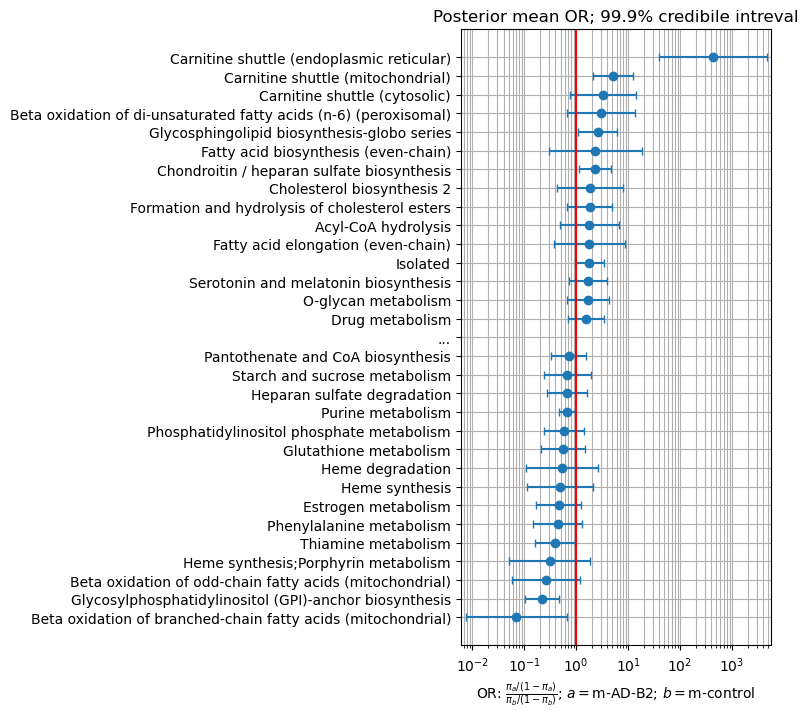

In [32]:
def credibility_plot(fe, alpha=0.0005, control_group='m-control', AD_group='m-AD-B2'):
    fe = exp_transform(fe, alpha=alpha)
    fig, ax = plt.subplots(figsize=(4, 8))
    ax.errorbar(x=fe.OR, y=list(range(fe.shape[0])), xerr=(fe.Lhalf_CI, fe.Uhalf_CI), linestyle='none', marker='o', capsize=3)
    ax.set_xscale('log')
    ax.set_xlim([0.8 * fe.Lbound.min(), 1.2 * fe.Ubound.max()])
    ax.set_yticks(list(range(fe.shape[0])))
    ax.set_yticklabels(fe.index)
    ax.grid(which='both')
    ax.axvline(1, color='red')
    ax.set_title(r'Posterior mean OR; ' + str(100 * (1 - 2 * alpha)) + '% credibile intreval')
    ax.set_xlabel(r'OR: $\frac{\pi_a / (1 - \pi_a)}{\pi_b / (1 - \pi_b)}$; $a =$' + AD_group + r'; $b =$' + control_group)
    return((fig, ax))

fig, ax = credibility_plot(fe_shortened)
attila_utils.savefig(fig, 'posterior-OR-top-bottom-subsystems')

## Illustrations

### Prior and posterior estimates and credible regions

['named-figure/CI-prior-posterior_Carnitine-shuttle-mitochondrial.png',
 'named-figure/CI-prior-posterior_Carnitine-shuttle-mitochondrial.pdf']

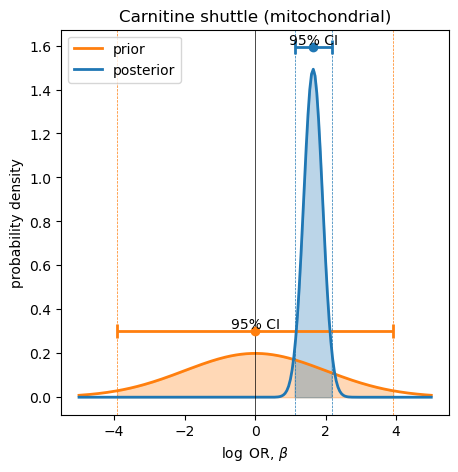

In [33]:
def CI_plot(ax, loc=0, scale=2, alpha=0.025, support=5, label=None, color='C0', CI_mode_off=None):
    n = 201
    x = np.linspace(-support, support, n)
    y = scipy.stats.norm.pdf(x, loc, scale)
    CI_halfwidth = scipy.stats.norm.ppf(1 - alpha, loc=0, scale=scale)
    CI = [loc - CI_halfwidth, loc + CI_halfwidth]
    linewidth = 2
    ax.plot(x, y, label=label, color=color, linewidth=linewidth)
    # credibility interval
    x_CI = np.linspace(*CI, n)
    # CI: fill under PDF
    ax.fill_between(x_CI, 0, scipy.stats.norm.pdf(x_CI, loc, scale), alpha=0.3, color=color)
    # CI: vertical lines
    vlinestyle = 'dashed'
    vlinewidth = 0.5
    ax.axvline(CI[0], linestyle=vlinestyle, linewidth=vlinewidth, color=color)
    ax.axvline(CI[1], linestyle=vlinestyle, linewidth=vlinewidth, color=color)
    # CI: error bar showing CI
    mode = scipy.stats.norm.pdf(loc, loc, scale)
    CI_y = mode + (CI_mode_off if CI_mode_off is not None else 0.1 * mode)
    ax.errorbar(x=loc, y=CI_y, xerr=CI_halfwidth, linewidth=linewidth, capthick=linewidth, marker='o', capsize=5, color=color)
    ax.text(x=loc, y=CI_y, s=str(int(100 * (1 - 2 * alpha))) + '% CI', verticalalignment='bottom', horizontalalignment='center')
    ax.set_xlabel(r'$\log$ OR, $\beta$')
    ax.set_ylabel('probability density')
    return(ax)

fig, ax = plt.subplots(figsize=(5,5))
CI_mode_off = 0.1
ax = CI_plot(ax, CI_mode_off=CI_mode_off, label='prior', color='C1')
subsys = 'Carnitine shuttle (mitochondrial)'
ax = CI_plot(ax, *fe.loc[subsys, ['fe_mean', 'fe_sd']], color='C0', CI_mode_off=CI_mode_off, label='posterior')
ax.axvline(0, color='black', linewidth=0.5)
ax.legend()
ax.set_title(subsys)
attila_utils.savefig(fig, 'CI-prior-posterior_Carnitine-shuttle-mitochondrial')

### Bayes factors

The default $H_0$ is $\log_2 \mathrm{OR} \in [-1, 1]$: at most $2\times$ change in the odds of active:inactive state in AD (subtype) relative to control.

['named-figure/Bayes-factor-posterior_Carnitine-shuttle-mitochondrial.png',
 'named-figure/Bayes-factor-posterior_Carnitine-shuttle-mitochondrial.pdf']

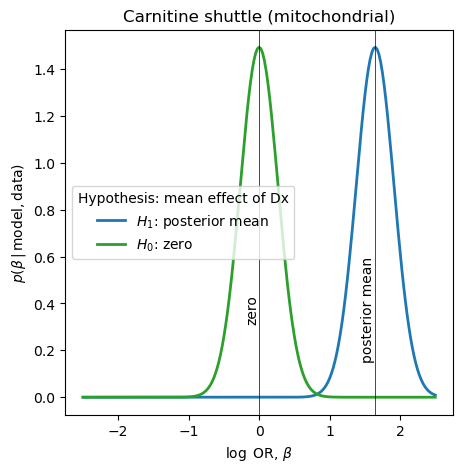

In [34]:
def hypothesis_plot(ax, loc=0, scale=2, support=5):
    n = 201
    x = np.linspace(-support, support, n)
    y = scipy.stats.norm.pdf(x, loc, scale)
    linewidth = 2
    ax.plot(x, y, color='C0', linewidth=linewidth, label=r'$H_1$: posterior mean')
    y0 = scipy.stats.norm.pdf(x, 0, scale)
    ax.plot(x, y0, color='C2', linewidth=linewidth, label=r'$H_0$: zero')
    ax.legend(title='Hypothesis: mean effect of Dx', loc='best')
    ax.set_xlabel(r'$\log$ OR, $\beta$')
    ax.set_ylabel(r'$p(\beta \, | \, \mathrm{model}, \mathrm{data})$')
    ax.axvline(0, color='black', linewidth=0.5)
    ax.axvline(loc, color='black', linewidth=0.5)
    ax.text(0, y.max() / 4, 'zero', rotation=90, verticalalignment='center', horizontalalignment='right')
    ax.text(loc, y.max() / 4, 'posterior mean', rotation=90, verticalalignment='center', horizontalalignment='right')
    return(ax)

fig, ax = plt.subplots(figsize=(5,5))
CI_mode_off = 0.1
subsys = 'Carnitine shuttle (mitochondrial)'
ax = hypothesis_plot(ax, *fe.loc[subsys, ['fe_mean', 'fe_sd']], support=2.5)
ax.set_title(subsys)
attila_utils.savefig(fig, 'Bayes-factor-posterior_Carnitine-shuttle-mitochondrial')

In [35]:
%connect_info

{
  "shell_port": 64999,
  "iopub_port": 65000,
  "stdin_port": 65001,
  "control_port": 65003,
  "hb_port": 65002,
  "ip": "127.0.0.1",
  "key": "1346a6f3-67d72f9c9ad47567a9c5a672",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-152afcfe-6969-40ff-83ca-9d88c75cc80d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
